In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os


In [23]:
# Paths to the correct and incorrect pronunciation folders
correct_folder = 'dataset\\Tajweed\\12_seen'
incorrect_folder = 'dataset\\Non Tajweed'

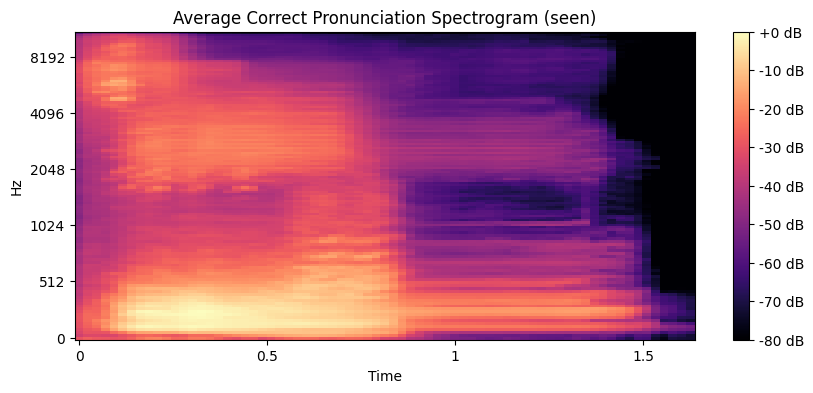

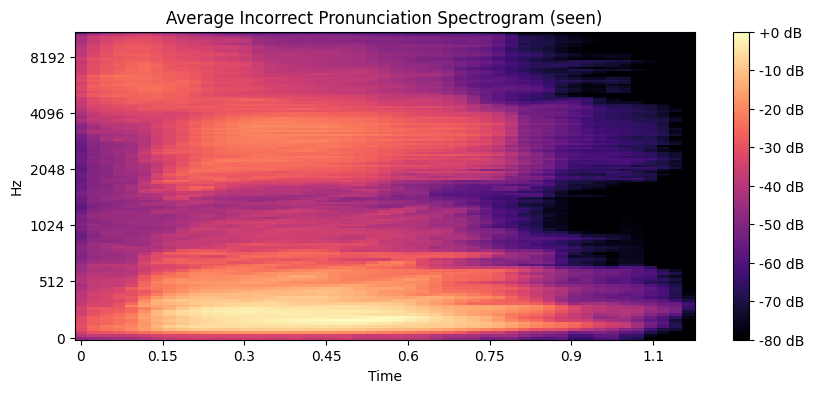

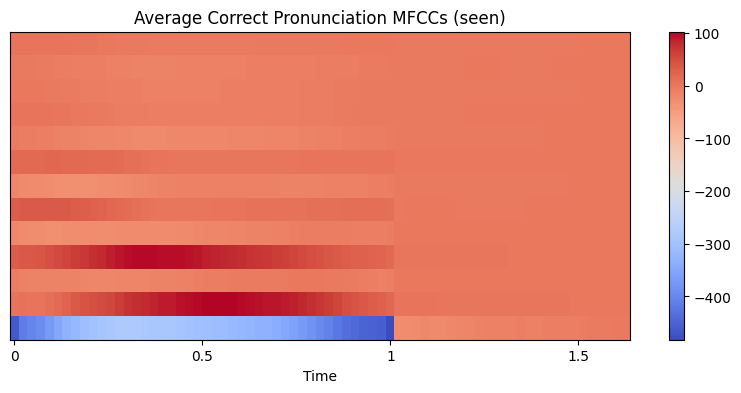

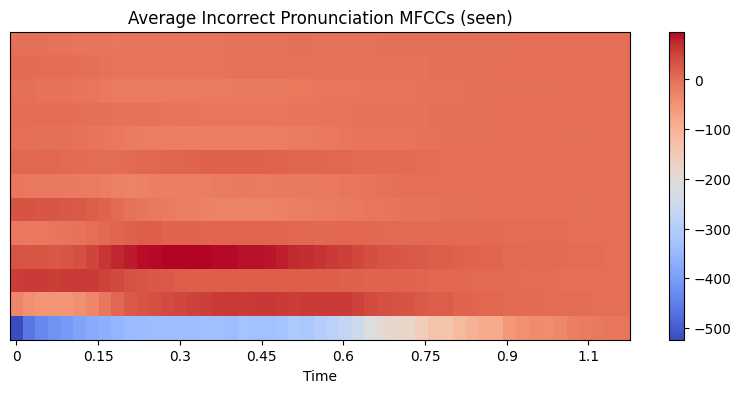

In [24]:
# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    
    # MFCC (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return mfccs, spectrogram

# Function to pad feature arrays to the same length
def pad_features(features, max_len):
    # If the feature array has fewer time steps than max_len, pad it with zeros
    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        return np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    # If it's longer, truncate it
    elif features.shape[1] > max_len:
        return features[:, :max_len]
    else:
        return features

# Function to process files and return averaged features
def process_folder(folder, letter_tag):
    all_mfccs = []
    all_spectrograms = []
    max_mfcc_len = 0
    max_spec_len = 0
    
    # Iterate through files in the folder
    for file in os.listdir(folder):
        # Process only files that contain the specified letter/tag in their name
        if letter_tag.lower() in file.lower():  # Case insensitive search
            file_path = os.path.join(folder, file)
            try:
                mfccs, spectrogram = extract_features(file_path)
                
                # Track the maximum length of MFCCs and spectrograms
                max_mfcc_len = max(max_mfcc_len, mfccs.shape[1])
                max_spec_len = max(max_spec_len, spectrogram.shape[1])
                
                # Append extracted features to the lists
                all_mfccs.append(mfccs)
                all_spectrograms.append(spectrogram)
            except (PermissionError, FileNotFoundError) as e:
                print(f"Skipping file {file_path} due to error: {e}")
    
    # Pad all feature arrays to the same length
    all_mfccs = [pad_features(mfcc, max_mfcc_len) for mfcc in all_mfccs]
    all_spectrograms = [pad_features(spec, max_spec_len) for spec in all_spectrograms]
    
    # Convert lists to arrays and compute the average MFCCs and spectrogram
    avg_mfccs = np.mean(all_mfccs, axis=0)
    avg_spectrogram = np.mean(all_spectrograms, axis=0)
    
    return avg_mfccs, avg_spectrogram

# Specify the letter/tag to filter the files (e.g., "seen" for the letter "س")
letter_tag = 'seen'  # Replace with your desired letter/tag

# Process both correct and incorrect folders for the specified letter/tag
incorrect_mfccs, incorrect_spectrogram = process_folder(incorrect_folder, letter_tag)
correct_mfccs, correct_spectrogram = process_folder(correct_folder, letter_tag)

# Plot the average spectrograms and MFCCs
if correct_mfccs is not None and incorrect_mfccs is not None:
    # Plot the average spectrograms for correct and incorrect samples
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(correct_spectrogram, ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Average Correct Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(incorrect_spectrogram, ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Average Incorrect Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    # Plot the average MFCCs for correct and incorrect samples
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(correct_mfccs, x_axis='time')
    plt.title(f'Average Correct Pronunciation MFCCs ({letter_tag})')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(incorrect_mfccs, x_axis='time')
    plt.title(f'Average Incorrect Pronunciation MFCCs ({letter_tag})')
    plt.colorbar()
    plt.show()
else:
    print(f"No valid data to plot for letter/tag: {letter_tag}")


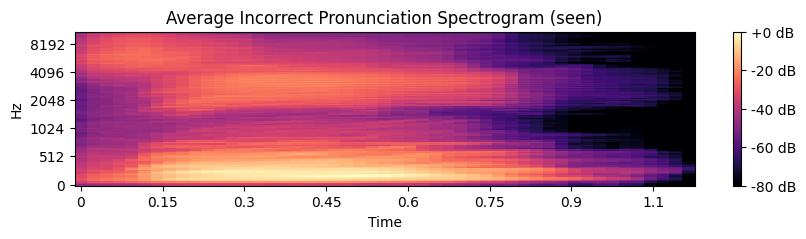

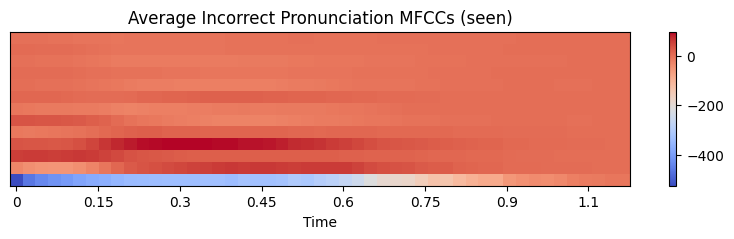

In [21]:
# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    
    # MFCC (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return mfccs, spectrogram

# Function to pad feature arrays to the same length
def pad_features(features, max_len):
    # If the feature array has fewer time steps than max_len, pad it with zeros
    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        return np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    # If it's longer, truncate it
    elif features.shape[1] > max_len:
        return features[:, :max_len]
    else:
        return features

# Function to process files and return averaged features
def process_folder(folder, letter_tag):
    all_mfccs = []
    all_spectrograms = []
    max_mfcc_len = 0
    max_spec_len = 0
    
    # Iterate through files in the folder
    for file in os.listdir(folder):
        # Process only files that contain the specified letter/tag in their name
        if letter_tag.lower() in file.lower():  # Case insensitive search
            file_path = os.path.join(folder, file)
            mfccs, spectrogram = extract_features(file_path)
            
            # Track the maximum length of MFCCs and spectrograms
            max_mfcc_len = max(max_mfcc_len, mfccs.shape[1])
            max_spec_len = max(max_spec_len, spectrogram.shape[1])
            
            # Append extracted features to the lists
            all_mfccs.append(mfccs)
            all_spectrograms.append(spectrogram)
    
    # Pad all feature arrays to the same length
    all_mfccs = [pad_features(mfcc, max_mfcc_len) for mfcc in all_mfccs]
    all_spectrograms = [pad_features(spec, max_spec_len) for spec in all_spectrograms]
    
    # Convert lists to arrays and compute the average MFCCs and spectrogram
    avg_mfccs = np.mean(all_mfccs, axis=0)
    avg_spectrogram = np.mean(all_spectrograms, axis=0)
    
    return avg_mfccs, avg_spectrogram

# Specify the letter/tag to filter the files (e.g., "seen" for the letter "س")
letter_tag = 'seen'  # Replace with your desired letter/tag

# Process both correct and incorrect folders for the specified letter/tag
incorrect_mfccs, incorrect_spectrogram = process_folder(incorrect_folder, letter_tag)
# correct_mfccs, correct_spectrogram = process_folder(correct_folder, letter_tag)

# Plot the average spectrograms and MFCCs
if incorrect_mfccs is not None:


    plt.figure(figsize=(10, 2))
    librosa.display.specshow(librosa.power_to_db(incorrect_spectrogram, ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Average Incorrect Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()


    plt.figure(figsize=(10, 2))
    librosa.display.specshow(incorrect_mfccs, x_axis='time')
    plt.title(f'Average Incorrect Pronunciation MFCCs ({letter_tag})')
    plt.colorbar()
    plt.show()
else:
    print(f"No valid data to plot for letter/tag: {letter_tag}")
